# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных.

Данные геологоразведки трёх регионов находятся в файлах:

- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv. 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
! pip  install  phik  -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

In [3]:
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
from itertools import combinations
from scipy import stats
from scipy.stats import spearmanr
import sklearn
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance


In [5]:
from phik import phik_matrix

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

### Загрузка данных и первичное знакомство.
На данном этапе необходимо загрузить данные , вывести их на экран и посмотреть общую информацию. По полученым данным сделать вывод.

In [7]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [8]:
display(data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [9]:
print(data_0.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [10]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [11]:
display(data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
print(data_1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [13]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [14]:
display(data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [15]:
print(data_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


**ВЫВОД** :
После загрузки данных и первичного просмотра файлов было установлено, что:
1. во всех данных корректно было введено название колон.
2. всем данным корректно присвоен тип данных.

В предобработке данные неоходимо проверить на пропуски и дубликаты.

### ПРЕДОБРАБОТКА ДАННЫХ
На данном этапе необходимо все данные проверить на наличие дубликатов, если они будут - замена будет проводиться в пайплайне. Также необходимо будет нумерации присвоить id.

In [16]:
print(data_0.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [17]:
print('количество строк в данных: ',data_0.shape[0])
print('количество дубликатов в данных: ',data_0.duplicated().sum())

количество строк в данных:  100000
количество дубликатов в данных:  0


In [18]:
print('количество дубликатов в данных по id: ',data_0['id'].duplicated().sum())

количество дубликатов в данных по id:  10


In [19]:
display(data_0[data_0['id'].duplicated() == True].sort_values(by = 'id'))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


In [20]:
data_0.drop_duplicates(subset=['id'],inplace=True)
print('количество дубликатов в данных по id: ',data_0['id'].duplicated().sum())
print('количество строк в данных: ',data_0.shape[0])

количество дубликатов в данных по id:  0
количество строк в данных:  99990


In [21]:
data_0 = data_0.set_index('id')
display(data_0.head())

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [22]:
print('количество строк в данных: ',data_0.shape[0])
print('количество дубликатов в данных: ',data_0.duplicated().sum())

количество строк в данных:  99990
количество дубликатов в данных:  0


In [23]:
print(data_1.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [24]:
print('количество строк в данных: ',data_1.shape[0])
print('количество дубликатов в данных: ',data_1.duplicated().sum())

количество строк в данных:  100000
количество дубликатов в данных:  0


In [25]:
print('количество дубликатов в данных по id: ',data_1['id'].duplicated().sum())

количество дубликатов в данных по id:  4


In [26]:
display(data_1[data_1['id'].duplicated() == True].sort_values(by = 'id'))

,id,f0,f1,f2,product
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [27]:
data_1.drop_duplicates(subset=['id'],inplace=True)
print('количество дубликатов в данных по id: ',data_1['id'].duplicated().sum())
print('количество строк в данных: ',data_1.shape[0])

количество дубликатов в данных по id:  0
количество строк в данных:  99996


In [28]:
data_1 = data_1.set_index('id')
display(data_1.head())

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [29]:
print('количество строк в данных: ',data_1.shape[0])
print('количество дубликатов в данных: ',data_1.duplicated().sum())

количество строк в данных:  99996
количество дубликатов в данных:  0


In [30]:
print(data_2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [31]:
print('количество строк в данных: ',data_2.shape[0])
print('количество дубликатов в данных: ',data_2.duplicated().sum())

количество строк в данных:  100000
количество дубликатов в данных:  0


In [32]:
print('количество дубликатов в данных по id: ',data_2['id'].duplicated().sum())

количество дубликатов в данных по id:  4


In [33]:
display(data_2[data_2['id'].duplicated() == True].sort_values(by = 'id'))

,id,f0,f1,f2,product
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [34]:
data_2.drop_duplicates(subset=['id'],inplace=True)
print('количество дубликатов в данных по id: ',data_2['id'].duplicated().sum())
print('количество строк в данных: ',data_2.shape[0])

количество дубликатов в данных по id:  0
количество строк в данных:  99996


In [35]:
data_2 = data_2.set_index('id')
display(data_2.head())

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


In [36]:
print('количество строк в данных: ',data_2.shape[0])
print('количество дубликатов в данных: ',data_2.duplicated().sum())

количество строк в данных:  99996
количество дубликатов в данных:  0


**ВЫВОД**

В предобработке данных каждый файл просматривался на наличие пропусков и дубликатов.

В данных нет пропусков.

В данных нет явных дубликатов.

Также было принято решение вместо нумерации использовать id скважины. Перед заменой был проведен поиск дубликатов среди id для каждых данных. Было выявлено в первом файле - 10, во втором и третьем - 4. Было принято решение их удалить. После удаления была произведена замена. После замены проверка на дубликаты выявило их отсутствие.

Суммарное число строк в первом файле - 99 990, во втором и третьем - 99 996.

### ИССЛЕДОВАТЕЛЬСКИЙ И КОРРЕЛЯЦИОННЫЕ АНАЛИЗЫ ДАННЫХ
На данном этапе необходимо исследовать данные на наличие аномалий в данных и по возможности их убрать. Также посмотреть на зависимость параметров друг от друга

In [37]:
test_0 = data_0.reset_index()

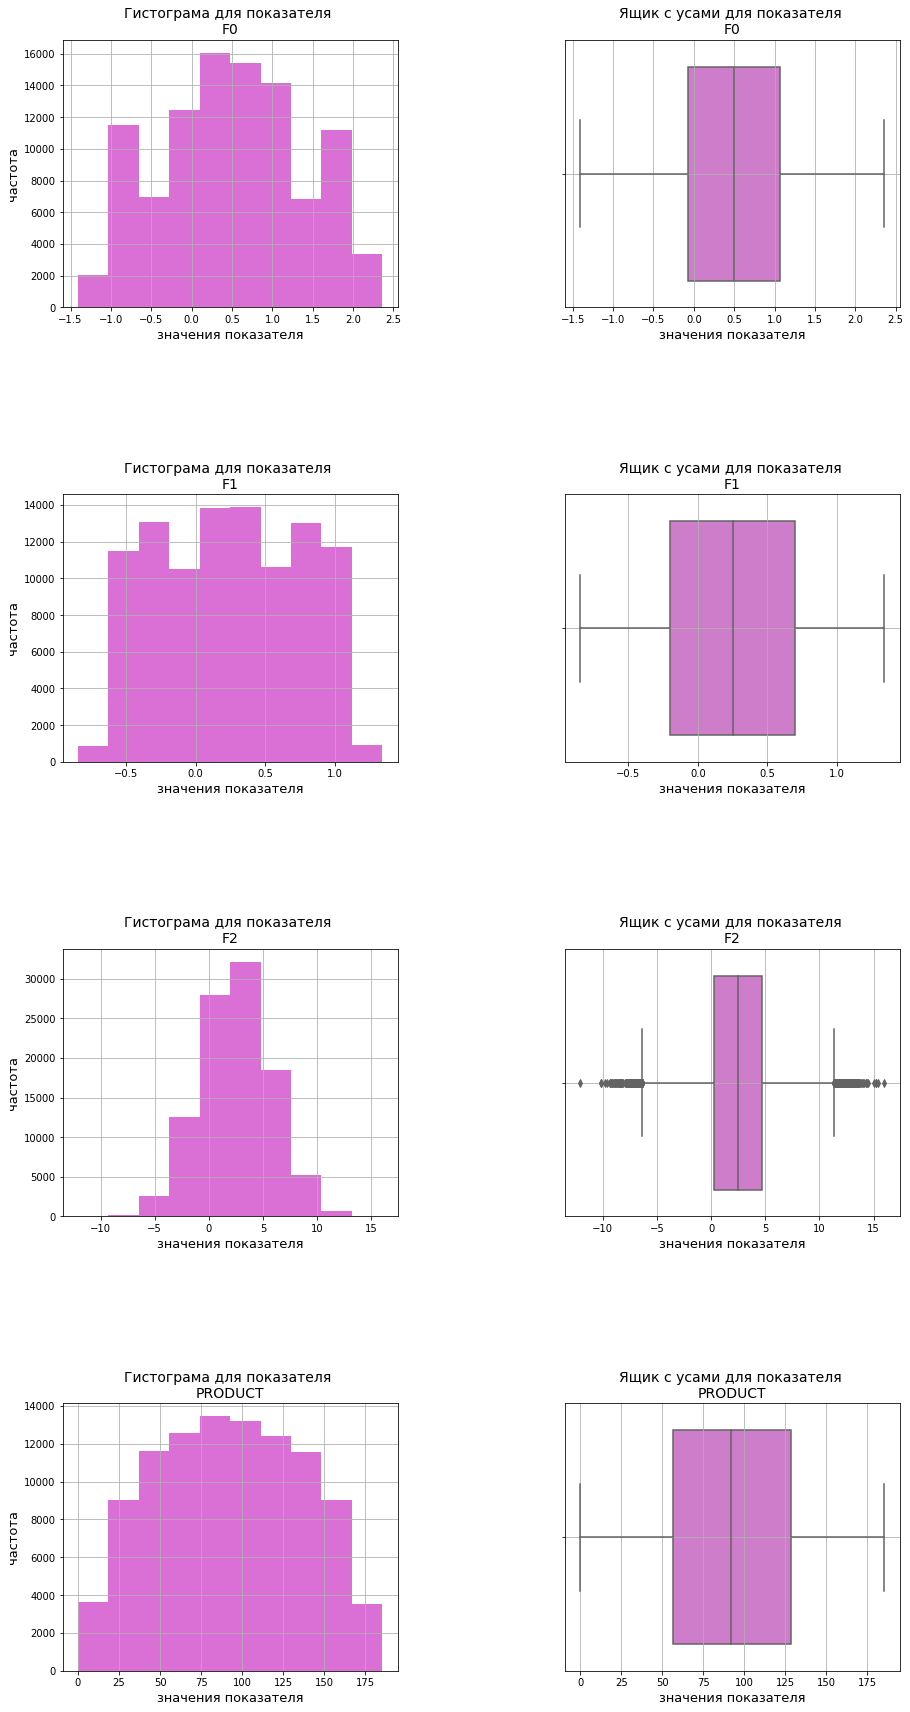

In [38]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_0[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_0[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [39]:
display(data_0.query('f2 < -12'))

,f0,f1,f2,product
id,,,,
Ri3EF,-0.94126,0.293833,-12.088328,25.069622


In [40]:
display(data_0.query('f2 > 15'))

,f0,f1,f2,product
id,,,,
Ue1K8,0.762994,0.742322,15.014250,76.184104
QFDWZ,1.092258,-0.541900,16.003790,182.079984
Fgte6,1.612452,-0.074593,15.230322,173.971897
R5IYz,0.879559,0.258449,15.202838,123.920559
xuWxm,1.888221,0.067384,15.428372,144.009283


In [41]:
data_0 = data_0.query('f2 > -12 and f2 < 15')
test_0 = data_0.reset_index()

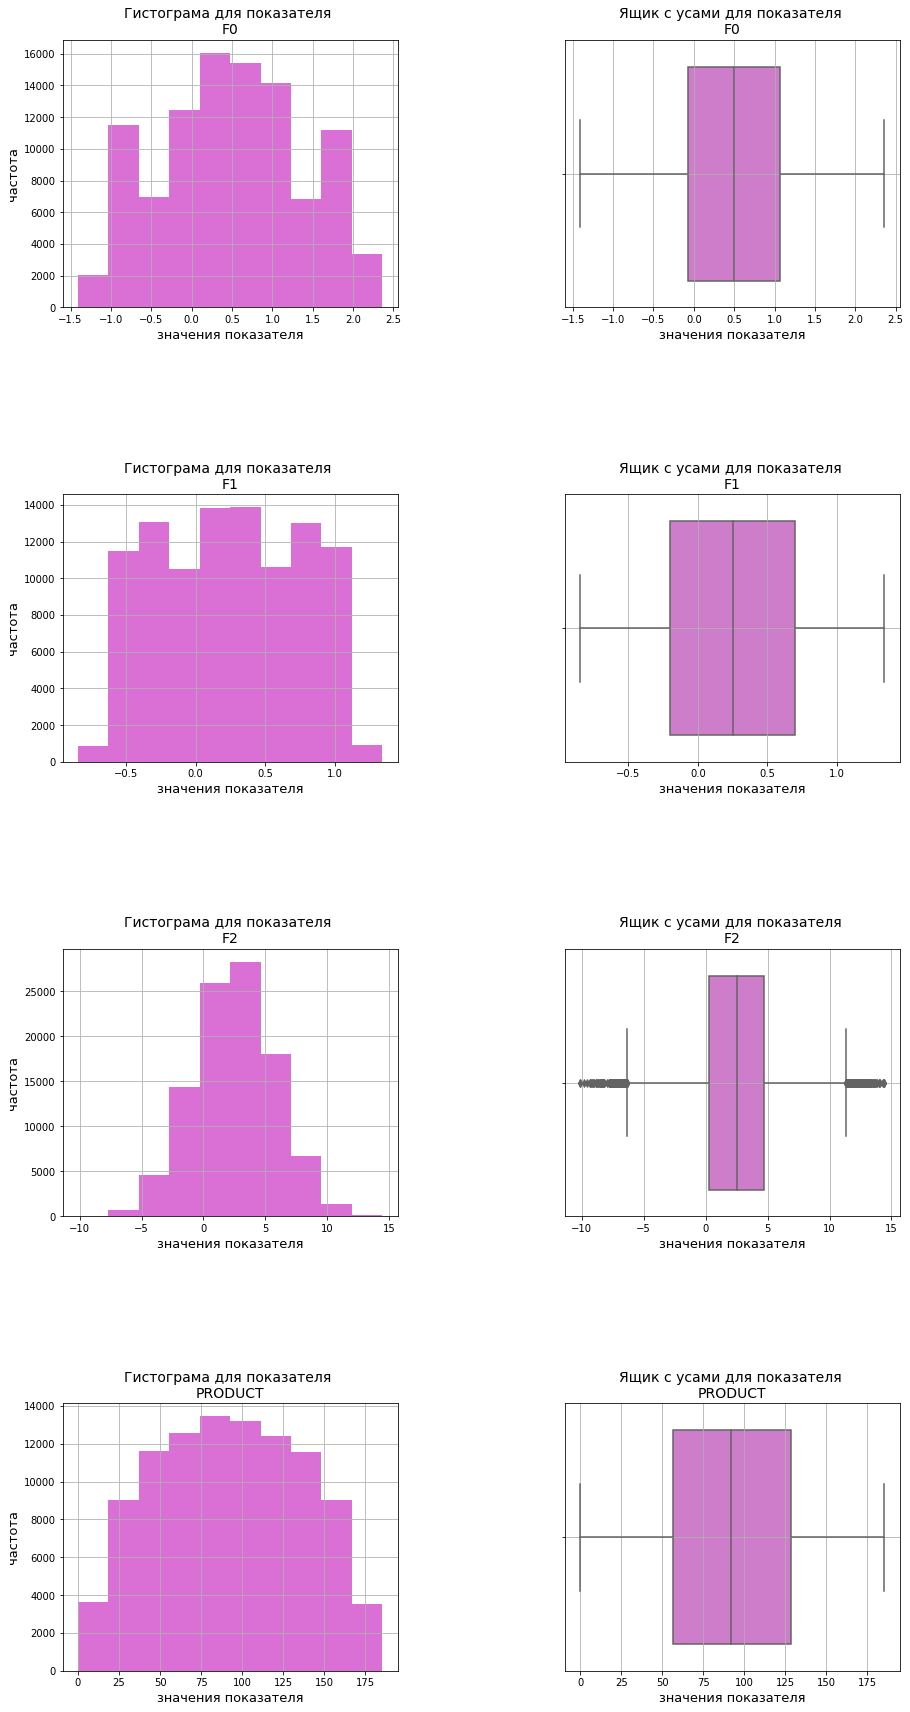

In [42]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_0[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_0[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [43]:
list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]


for name in list:
    df1 = test_0[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя F0
count    99984.000000
mean         0.500432
std          0.871837
min         -1.408605
25%         -0.072580
50%          0.502360
75%          1.073581
max          2.362331
Name: f0, dtype: float64 

Характеристики количественного показателя F1
count    99984.000000
mean         0.250148
std          0.504435
min         -0.848218
25%         -0.200881
50%          0.250252
75%          0.700646
max          1.343769
Name: f1, dtype: float64 

Характеристики количественного показателя F2
count    99984.000000
mean         2.502131
std          3.246642
min        -10.138341
25%          0.287748
50%          2.515919
75%          4.714821
max         14.437300
Name: f2, dtype: float64 

Характеристики количественного показателя PRODUCT
count    99984.000000
mean        92.497982
std         44.287022
min          0.000000
25%         56.496846
50%         91.844680
75%        128.561082
max        185.364347
Name: product, dtype: float64 

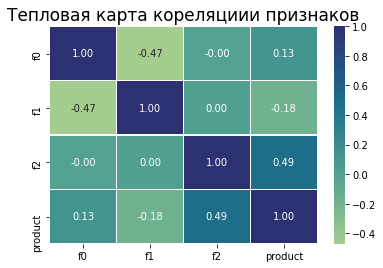

In [44]:
plt.figure(figsize=(6, 4));
sns.heatmap(
    data_0.corr(method='spearman')
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


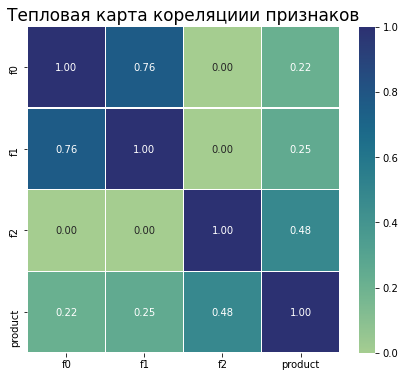

In [45]:
plt.figure(figsize=(7, 6));
sns.heatmap(
    data_0.phik_matrix()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

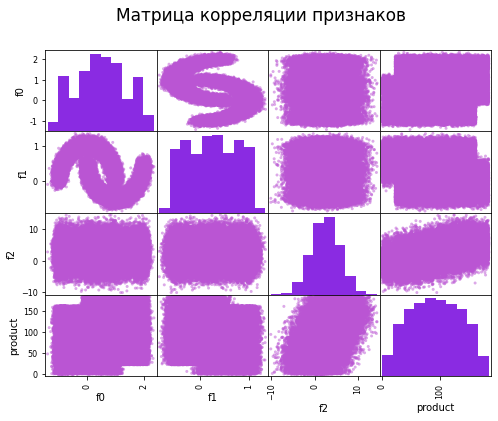

In [46]:
pd.plotting.scatter_matrix(test_0, figsize=(8, 6), alpha=0.5, 
c='mediumorchid', hist_kwds={'color':['blueviolet']});
plt.suptitle('Матрица корреляции признаков', fontsize=17);

**ВЫВОД**

После исследовательского и корреляционного анализов данных data_0 :
- были убраны аномалии в показателях f2, установив диапазон от -12 до 15.
- было установлено, все показатели имеют профиль похожий на нормальное распределение
- среднее значение f0 составляет 0.50 и лежит в диапазоне (-0.07; 1.07)
- среднее значение f1 составляет 0.25 и лежит в диапазоне (-0.20; 0.70)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.29; 4.71)
- среднее значение product составляет 92.50 и лежит в диапазоне (56.50; 128.56)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 умеренная корреляция,а между признаками f0 и f1 высокая корреляция.

In [47]:
test_1 = data_1.reset_index()

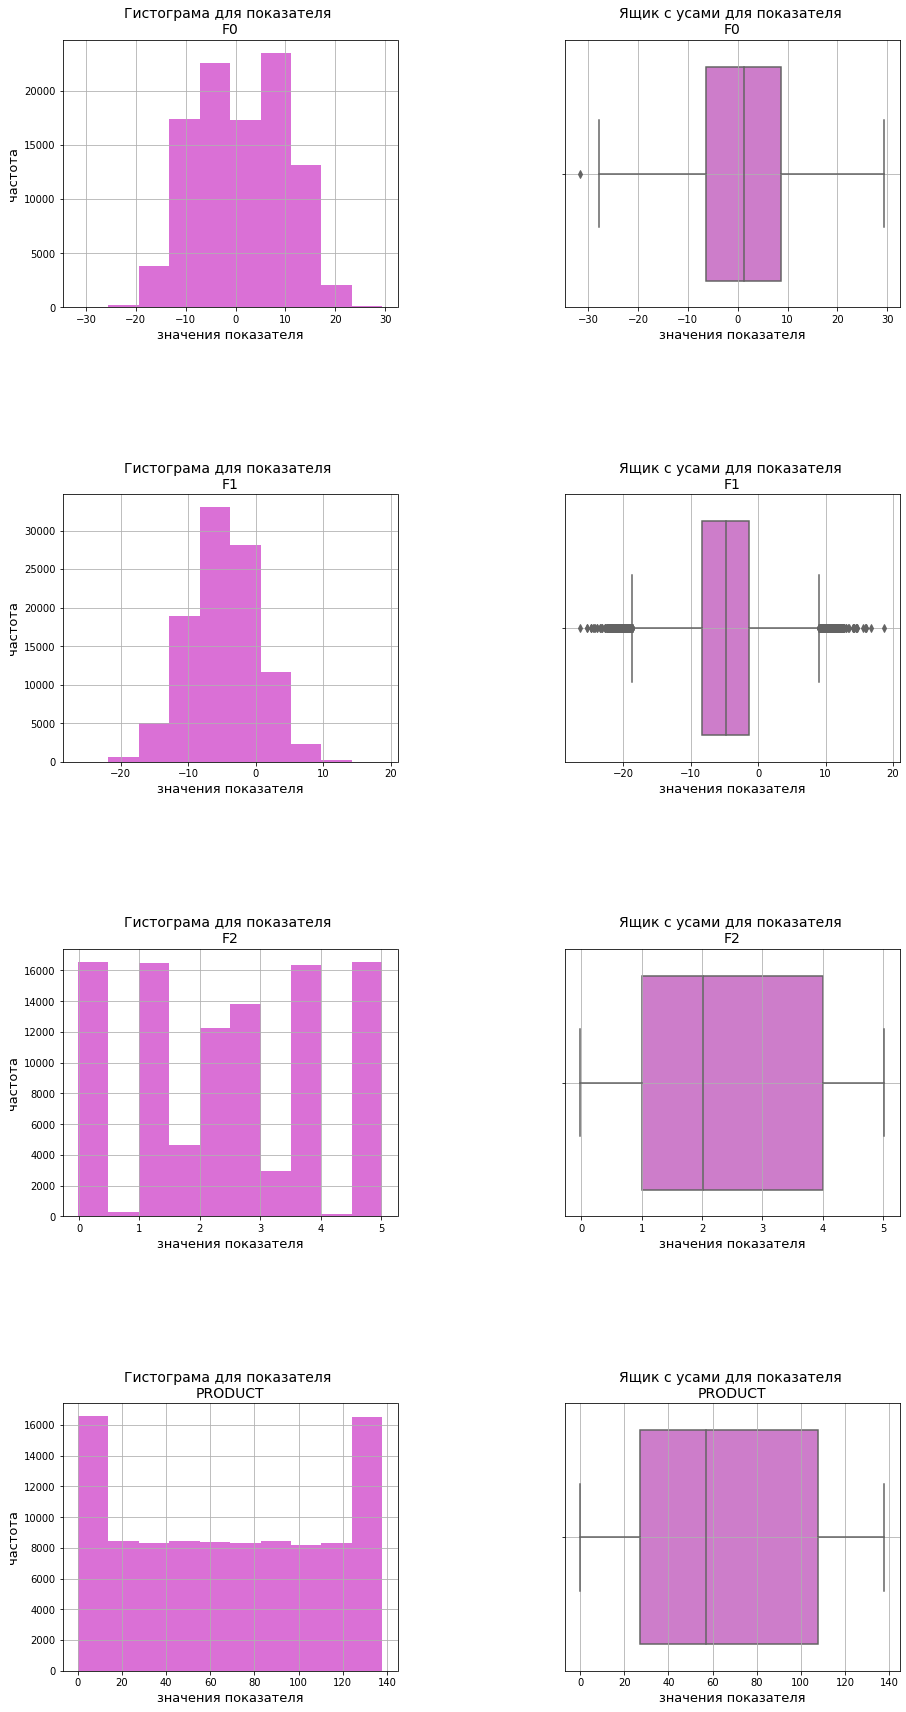

In [48]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_1[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [49]:
display(data_1.query('f0 < -30'))

,f0,f1,f2,product
id,,,,
jJm67,-31.609576,1.390042,4.001055,110.992147


In [50]:
display(data_1.query('f1 < -25'))

,f0,f1,f2,product
id,,,,
8aDLd,-12.917985,-25.389622,2.004006,57.085625
vkz7N,-1.598019,-26.358598,1.000528,30.132364
uhgl5,-16.454242,-25.291518,3.007387,84.038886


In [51]:
display(data_1.query('f1 > 16'))

,f0,f1,f2,product
id,,,,
EPUN0,-10.478652,16.737196,2.004495,57.085625
n69Ep,8.009292,16.026869,2.999571,80.859783
A0TZE,13.312093,18.734063,1.011698,26.953261


In [52]:
display(data_1.query('product == 0'))

,f0,f1,f2,product
id,,,,
OXyvW,16.320755,-0.562946,-0.001783,0.0
igmai,6.695604,-0.749449,-0.007630,0.0
Qjy5w,21.418478,-5.134490,-0.002836,0.0
G6WCj,6.822701,3.104979,-0.000723,0.0
MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
YrRU8,5.085749,-3.980305,0.005063,0.0
Jbnur,8.277805,-9.178818,0.003275,0.0
aV1cJ,13.343983,-1.290200,0.005980,0.0


In [53]:
data_1 = data_1.query('f0 > -30 and f1 > -25 and f1 < 16')
test_1 = data_1.reset_index()

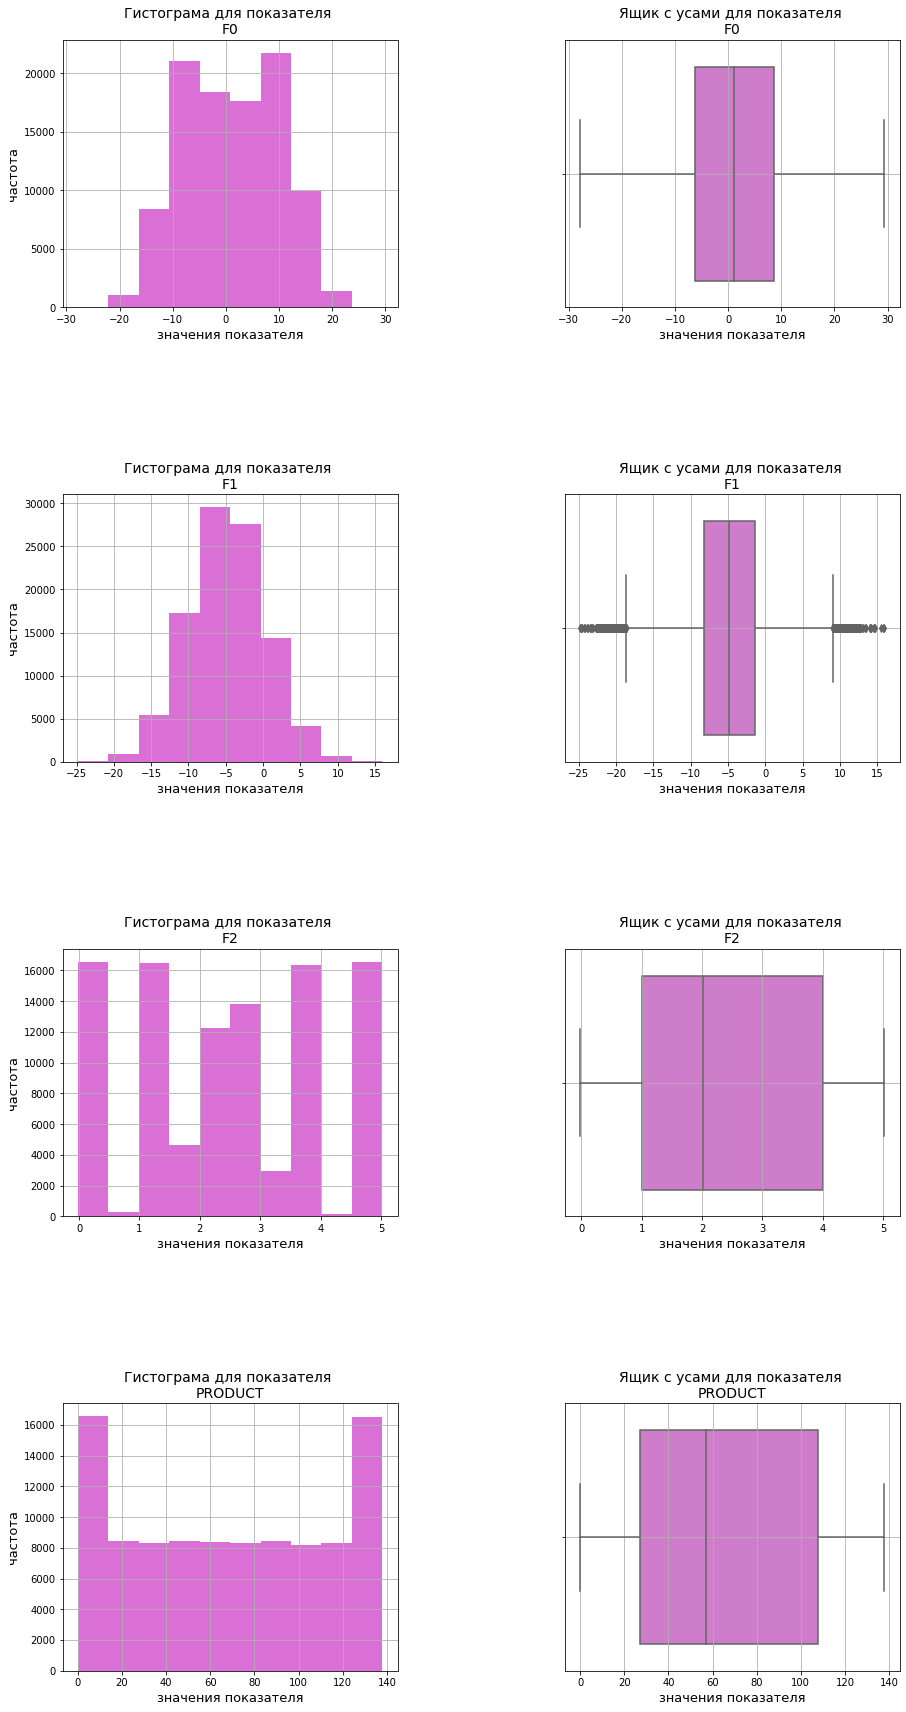

In [54]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_1[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_1[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [55]:
list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]


for name in list:
    df1 = test_1[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя F0
count    99989.000000
mean         1.141806
std          8.965059
min        -27.829616
25%         -6.298111
50%          1.153252
75%          8.620998
max         29.421755
Name: f0, dtype: float64 

Характеристики количественного показателя F1
count    99989.000000
mean        -4.796702
std          5.117351
min        -24.811711
25%         -8.267925
50%         -4.813297
75%         -1.332933
max         15.965151
Name: f1, dtype: float64 

Характеристики количественного показателя F2
count    99989.000000
mean         2.494515
std          1.703616
min         -0.018144
25%          1.000018
50%          2.011477
75%          3.999904
max          5.019721
Name: f2, dtype: float64 

Характеристики количественного показателя PRODUCT
count    99989.000000
mean        68.824262
std         45.945653
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64 

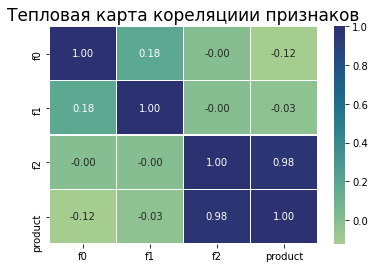

In [56]:
plt.figure(figsize=(6, 4));
sns.heatmap(
    data_1.corr(method='spearman')
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


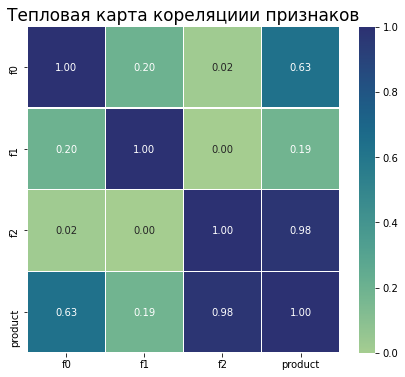

In [57]:
plt.figure(figsize=(7, 6));
sns.heatmap(
    data_1.phik_matrix()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

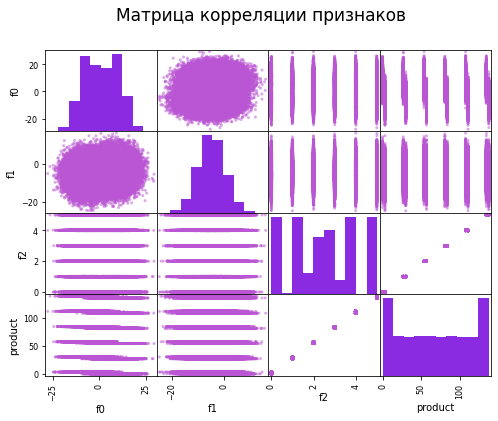

In [58]:
pd.plotting.scatter_matrix(test_1, figsize=(8, 6), alpha=0.5, 
c='mediumorchid', hist_kwds={'color':['blueviolet']});
plt.suptitle('Матрица корреляции признаков', fontsize=17);

**ВЫВОД**

После исследовательского и корреляционного анализов данных data_1 :
- были убраны аномалии в показателях f0, установив диапазон от -30. 
- были убраны аномалии в показателях f1, установив диапазон от -25 до 16.
- показатель f2 представлен ,как будто, в виде категориального параметра, что связано, возможно с програмным забитием его вручную. Такая же ситуация и у параметра product.
- было установлено, показатели, которые имеют профиль похожий на нормальное распределение: f0, f1.
- среднее значение f0 составляет 1.14 и лежит в диапазоне (-27.83; 8.62)
- среднее значение f1 составляет -4.79 и лежит в диапазоне (-8.27; -1.34)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (1.00; 3.99)
- среднее значение product составляет 68.82 и лежит в диапазоне (26.95; 107.81)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 очень высокая корреляция(это обьясняется тем, что данные параметры были вбиты вручную, возможно с использоваием формулы),а между признаками f0 и product средняя корреляция. 

In [59]:
test_2 = data_2.reset_index()

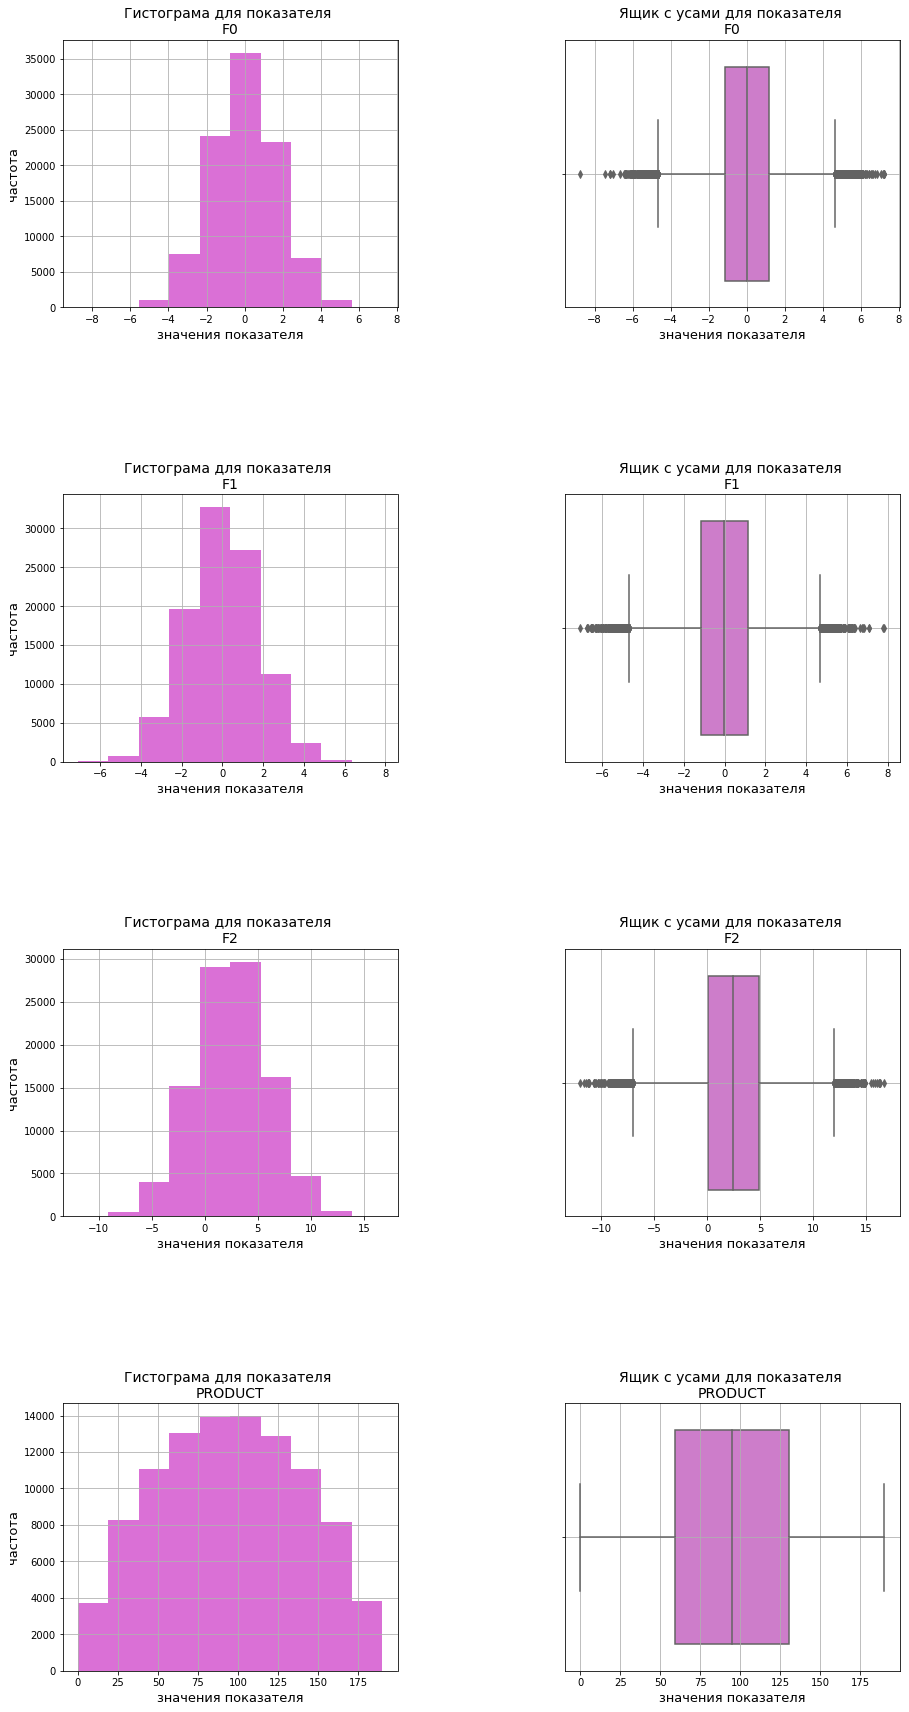

In [60]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_2[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_2[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [61]:
display(data_2.query('f0 < -8'))

,f0,f1,f2,product
id,,,,
onzVI,-8.760004,2.528391,6.552393,163.580588


In [62]:
display(data_2.query('f1 < -7'))

,f0,f1,f2,product
id,,,,
W9XXe,1.636305,-7.08402,4.687781,115.975856


In [63]:
display(data_2.query('f1 > 7'))

,f0,f1,f2,product
id,,,,
2KTc5,1.538759,7.080620,-0.947481,39.297867
RhjNI,0.240244,7.101618,2.843543,67.638082
KuaAc,-1.440037,7.844801,-2.068367,55.070925
Ttv5F,1.634977,7.761857,7.244834,128.645455


In [64]:
data_2 = data_2.query('f0 > -8 and f1 > -7 and f1 < 7')
test_2 = data_2.reset_index()

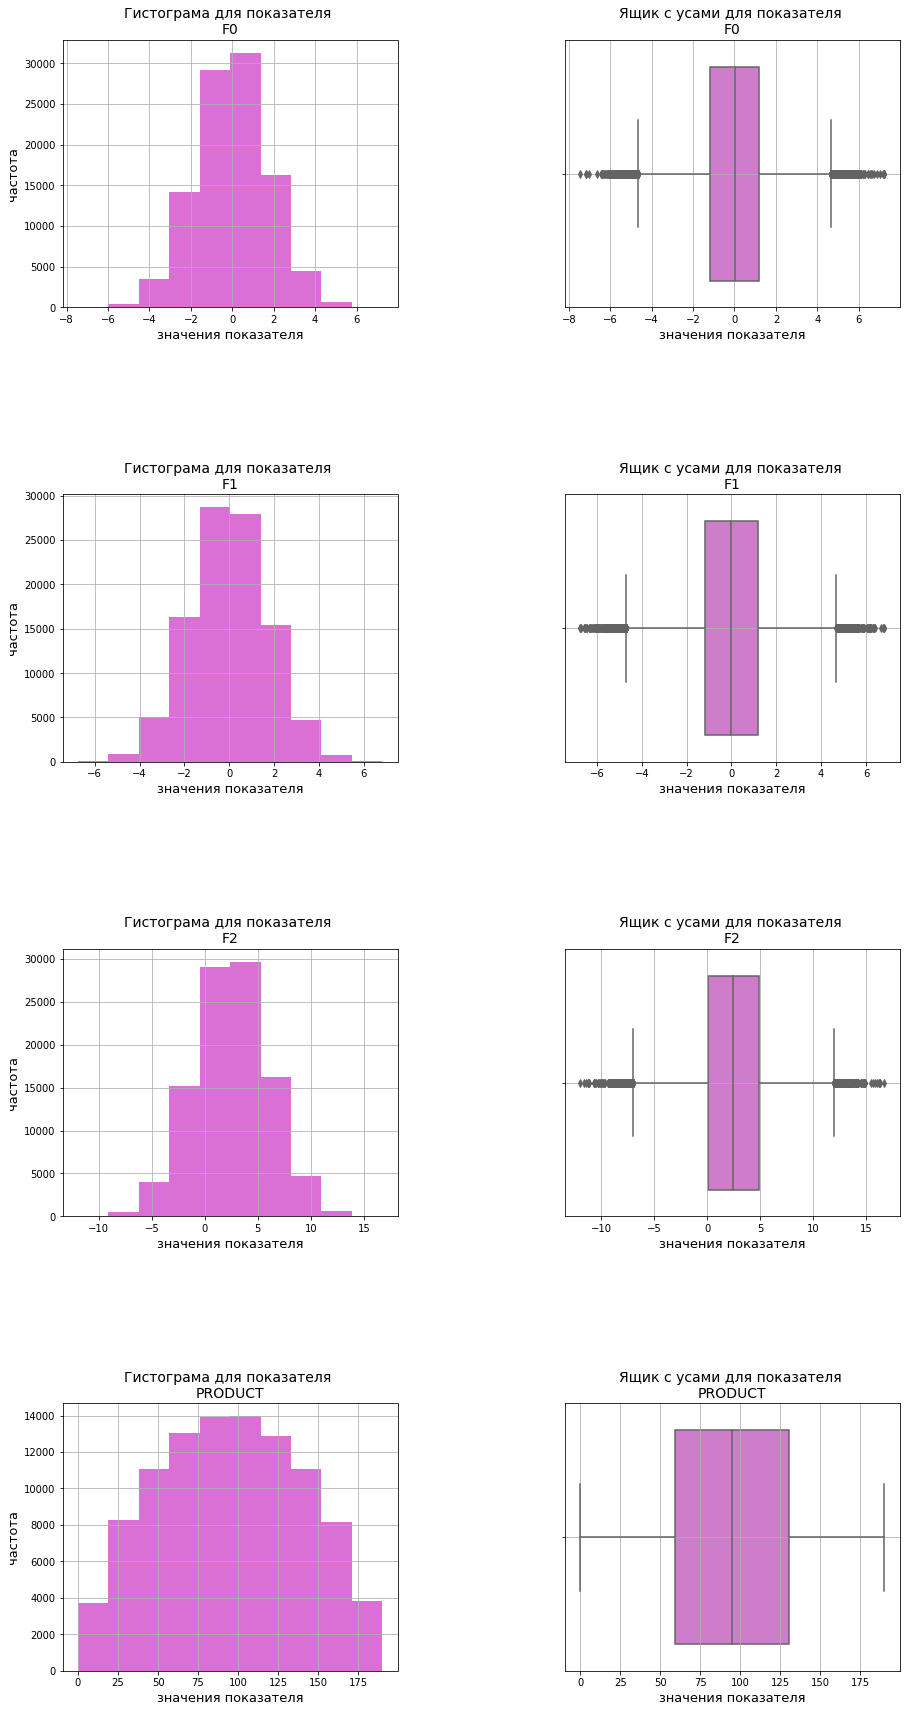

In [65]:
position = 0
plt.figure(figsize=[15,30])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]

for name in list:
    position += 1
    
    df1 = test_2[name]
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Гистограма для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = test_2[name]
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для показателя \n{name.upper()}', fontsize=14)
    plt.xlabel('значения показателя',fontsize=13 )
    plt.grid(True);

In [66]:
list = [ 
    'f0',
    'f1',
    'f2',
    'product'
]


for name in list:
    df1 = test_2[name]
    print(f'Характеристики количественного показателя {name.upper()}')
    print(df1.describe(),'\n')

Характеристики количественного показателя F0
count    99990.000000
mean         0.002054
std          1.731854
min         -7.450587
25%         -1.162309
50%          0.009411
75%          1.158433
max          7.238262
Name: f0, dtype: float64 

Характеристики количественного показателя F1
count    99990.000000
mean        -0.002411
std          1.729643
min         -6.748357
25%         -1.174854
50%         -0.009671
75%          1.163453
max          6.824058
Name: f1, dtype: float64 

Характеристики количественного показателя F2
count    99990.000000
mean         2.495050
std          3.473476
min        -11.970335
25%          0.130320
50%          2.484188
75%          4.858691
max         16.739402
Name: f2, dtype: float64 

Характеристики количественного показателя PRODUCT
count    99990.000000
mean        94.998340
std         44.749605
min          0.000000
25%         59.450258
50%         94.925026
75%        130.588581
max        190.029838
Name: product, dtype: float64 

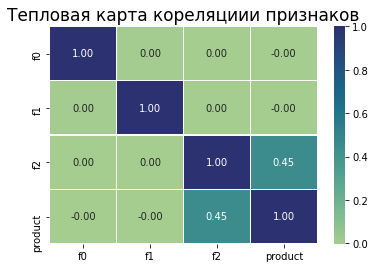

In [67]:
plt.figure(figsize=(6, 4));
sns.heatmap(
    data_2.corr(method='spearman')
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


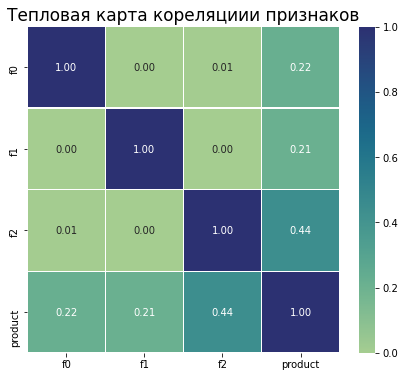

In [68]:
plt.figure(figsize=(7, 6));
sns.heatmap(
    data_2.phik_matrix()
    ,annot = True
    ,fmt = '.2f'
    ,linewidth=.5
    ,cmap="crest"
);
plt.title('Тепловая карта кореляциии признаков', fontsize=17);

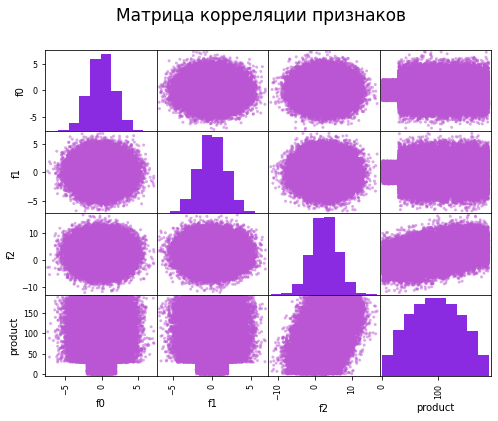

In [69]:
pd.plotting.scatter_matrix(test_2, figsize=(8, 6), alpha=0.5, 
c='mediumorchid', hist_kwds={'color':['blueviolet']});
plt.suptitle('Матрица корреляции признаков', fontsize=17);

После исследовательского и корреляционного анализов данных data_2 :
- были убраны аномалии в показателях f0, установив диапазон от -8. f0 > -8 and f1 > -7 and f1 < 7'
- были убраны аномалии в показателях f1, установив диапазон от -7 до 7.
- было установлено, все показатели имеют профиль, похожий на нормальное распределение.
- среднее значение f0 составляет 0.00 и лежит в диапазоне (-7.45; 1.16)
- среднее значение f1 составляет -0.00 и лежит в диапазоне (-1.17; 1.16)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.13; 4.85)
- среднее значение product составляет 94.99 и лежит в диапазоне (59.45; 130.59)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 слабая корреляция.

**ВЫВОД**

Был проведен исследовательский и корреляционный анализы для данных data_0, data_1, data_2.

После исследовательского и корреляционного анализов данных data_0 :
- были убраны аномалии в показателях f2, установив диапазон от -12 до 15.
- было установлено, все показатели имеют профиль похожий на нормальное распределение
- среднее значение f0 составляет 0.50 и лежит в диапазоне (-0.07; 1.07)
- среднее значение f1 составляет 0.25 и лежит в диапазоне (-0.20; 0.70)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.29; 4.71)
- среднее значение product составляет 92.50 и лежит в диапазоне (56.50; 128.56)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 умеренная корреляция,а между признаками f0 и f1 высокая корреляция.

После исследовательского и корреляционного анализов данных data_1 :
- были убраны аномалии в показателях f0, установив диапазон от -30 до 15. 
- были убраны аномалии в показателях f1, установив диапазон от -25 до 16.
- показатель f2 представлен ,как будто, в виде категориального параметра, что связано, возможно с програмным забитием его вручную. Такая же ситуация и у параметра product.
- было установлено, показатели, которые имеют профиль похожий на нормальное распределение: f0, f1.
- среднее значение f0 составляет 1.14 и лежит в диапазоне (-27.83; 8.62)
- среднее значение f1 составляет -4.79 и лежит в диапазоне (-8.27; -1.34)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (1.00; 3.99)
- среднее значение product составляет 68.82 и лежит в диапазоне (26.95; 107.81)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 очень высокая корреляция(это обьясняется тем, что данные параметры были вбиты вручную, возможно с использоваием формулы),а между признаками f0 и product средняя корреляция.

После исследовательского и корреляционного анализов данных data_2 :
- были убраны аномалии в показателях f0, установив диапазон от -8. f0 > -8 and f1 > -7 and f1 < 7'
- были убраны аномалии в показателях f1, установив диапазон от -7 до 7.
- было установлено, все показатели имеют профиль, похожий на нормальное распределение.
- среднее значение f0 составляет 0.00 и лежит в диапазоне (-7.45; 1.16)
- среднее значение f1 составляет -0.00 и лежит в диапазоне (-1.17; 1.16)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.13; 4.85)
- среднее значение product составляет 94.99 и лежит в диапазоне (59.45; 130.59)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 слабая корреляция.

Примечательно то, что для параметра f2 для всех зданных одинаковое среднее значение.

## Обучение и проверка модели
Необходимо обучить и проверить модель для каждого региона, для этого необходимо:
- разбить данные на обучающую и валидационную выборки в соотношении 75:25. 
- обучить модель и сделать предсказания на валидационной выборке. 
- сохранить предсказания и правильные ответы на валидационной выборке. 
- напечатать на экране средний запас предсказанного сырья и RMSE модели и сделать выводы.

In [70]:
num_columns = ['f0', 'f1','f2']

In [71]:
data_preprocessor = ColumnTransformer(
                    [('num', MinMaxScaler(), num_columns)],
                      remainder='passthrough')

In [72]:
pipe_final = Pipeline([('preprocessor', data_preprocessor)
                       ,('models',LinearRegression())])

In [73]:
param_grid = [{'models': [LinearRegression( )],
              'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]
param_grid

[{'models': [LinearRegression()],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [74]:
def prediction(data, target):
    features = data.drop([target] , axis=1)
    target = data[target]
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    model = pipe_final.fit(features_train, target_train)
    predicted_target = model.predict(features_valid) 
    
    data = {'real_product' : target_valid,
            'predicted_product' : predicted_target         
    }
    data_new = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    data_new = data_new.reset_index(drop=True)
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean=  predicted_target.mean()
    real_mean = target.mean()
    difference_mean = real_mean - mean
    return data_new, rmse, mean,real_mean,difference_mean

In [75]:
data_new_0, rmse, predicted_mean,real_mean,difference = prediction(data_0,'product')
display(data_new_0.head())
print('RMSE : ',round(rmse, 2))
print('Средний запас запасанного сырья : ',round(predicted_mean,2))
print('Средний реальный запас сырья', round(real_mean.mean(),2))
print('Разница между реальным и предсказанным запасами сырья', round(difference,2))

,real_product,predicted_product
0,125.670645,131.767214
1,155.571687,128.407875
2,128.195083,87.950185
3,65.422491,44.910595
4,2.422518,69.703588


RMSE :  37.67
Средний запас запасанного сырья :  92.71
Средний реальный запас сырья 92.5
Разница между реальным и предсказанным запасами сырья -0.21


In [76]:
data_new_1, rmse, predicted_mean,real_mean,difference = prediction(data_1,'product')
print('RMSE : ',round(rmse, 2))
print('Средний запас запасанного сырья : ',round(predicted_mean,2))
print('Средний реальный запас сырья', round(real_mean.mean(),2))
print('Разница между реальным и предсказанным запасами сырья', round(difference,2))

RMSE :  0.88
Средний запас запасанного сырья :  69.15
Средний реальный запас сырья 68.82
Разница между реальным и предсказанным запасами сырья -0.33


In [77]:
data_new_2, rmse, predicted_mean,real_mean,difference = prediction(data_2,'product')
print('RMSE : ',round(rmse, 2))
print('Средний запас запасанного сырья : ',round(predicted_mean,2))
print('Средний реальный запас сырья', round(real_mean.mean(),2))
print('Разница между реальным и предсказанным запасами сырья', round(difference,2))

RMSE :  40.19
Средний запас запасанного сырья :  94.88
Средний реальный запас сырья 95.0
Разница между реальным и предсказанным запасами сырья 0.12


**ВЫВОД**

Для решения данной задачи, было сделано:
- разделены все данные на обучающую и валидационную выборки в соотношении 75:25.
- созданы и обучены модели LinearRegression.
- выполнены предсказания на валидационной выборке
- сделаны предсказания по объёму сырья в скважинах.

Рассчитаны значения среднего запаса предсказанного сырья и RMSE моделей:
- для data_0 :
  - RMSE :  37.97
  - Средний запас запасанного сырья :  92.45
  - Средний реальный запас сырья 92.5
  - Разница между реальным и предсказанным запасами сырья 0.04
- для data_1 :
  - RMSE :  0.89
  - Средний запас запасанного сырья :  68.52
  - Средний реальный запас сырья 68.82
  - Разница между реальным и предсказанным запасами сырья 0.31
- для data_2 RMSE модели = 40.13
  - RMSE :  40.13
  - Средний запас запасанного сырья :  94.83
  - Средний реальный запас сырья 95.0
  - Разница между реальным и предсказанным запасами сырья 0.17

Самая лучшая оцена RMSE получилось на втором датасете - 0.89.Средний запас сырья лучше предсказано первом датасете, разница 0.04.

## Подготовка к расчёту прибыли

In [78]:
points = 500
best_points = 200
reg_budget = 10000000000
profit_per_units = 450000

In [79]:
avg_points = reg_budget/best_points
avg_barr_points = avg_points/profit_per_units
avg_barr_reg = reg_budget/profit_per_units
print(f" Средний доход по точкам {round(avg_points,2)} руб.")
print(f"Средний обьём по точкам {round(avg_barr_points,2)} бар.")
print(f"Средний обьём по региону {round(avg_barr_reg,2)} бар.")

 Средний доход по точкам 50000000.0 руб.
Средний обьём по точкам 111.11 бар.
Средний обьём по региону 22222.22 бар.


In [80]:
print(f"Средний фактический запас для data_0: {round(data_0['product'].mean(),2)} тыс. бар.")
print(f"Средний фактический запас для data_1: {round(data_1['product'].mean(),2)} тыс. бар.")
print(f"Средний фактический запас для data_2: {round(data_2['product'].mean(),2)} тыс. бар.")

Средний фактический запас для data_0: 92.5 тыс. бар.
Средний фактический запас для data_1: 68.82 тыс. бар.
Средний фактический запас для data_2: 95.0 тыс. бар.


**ВЫВОД**
Исходя из полученных данных, первый и третий регион находятся ближе всего к среднему значению по запасу нефти.

## Расчёт прибыли и рисков 

In [81]:
def risk_profit(target, predictions): 
    selected = target[predictions.index][:best_points]   
    if target[predictions.index].shape[0] != predictions.shape[0]:
        print(f"Shape mismatch! You took {target[predictions.index].shape[0]} target values!")
    return (profit_per_units * selected.sum() - reg_budget) / 1000000 

Регион 0
Средняя выручка : 448.87
Доверительный интервал: [ -57.1 : 953.806 ]
Риск:  3.3 %

Регион 1
Средняя выручка : 487.24
Доверительный интервал: [ 93.815 : 898.194 ]
Риск:  0.5 %

Регион 2
Средняя выручка : 335.34
Доверительный интервал: [ -187.244 : 888.406 ]
Риск:  10.2 %



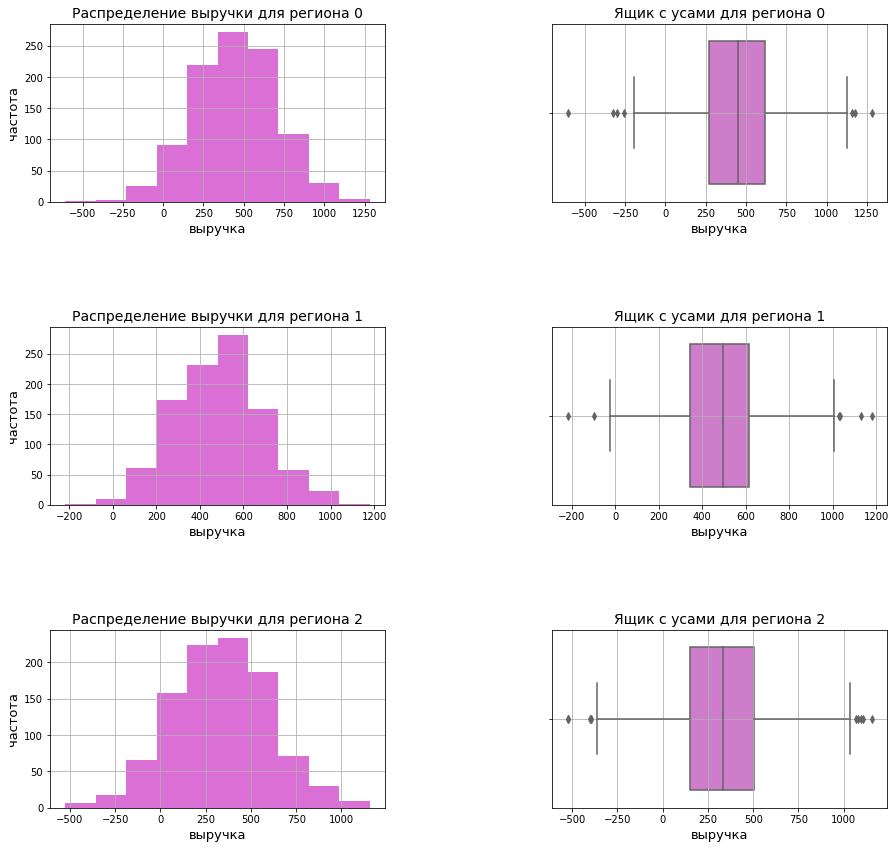

In [83]:
region = 0

position = 0
plt.figure(figsize=[15,20])
plt.subplots_adjust(wspace=0.5, hspace=0.7)

for data in [data_new_0, data_new_1, data_new_2]:
    values = []
    state = np.random.RandomState(12345)
  
    for i in range(1000):
        subset = data.sample(n=500, replace=True, random_state=state).reset_index(drop=True).sort_values(by='predicted_product', ascending=False)
        values.append(risk_profit(subset['real_product'], subset['predicted_product']))

    values = pd.Series(values)
  
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    #risk = stats.percentileofscore(values, 0)
    risk = round(values.apply(lambda x: x < 0).sum()/len(values)*100,3)
    
    print('Регион', region)
    print('Средняя выручка :', round(mean, 2))
    print('Доверительный интервал: [', round(lower,3), ':', round(upper,3), ']')
    print('Риск: ', round(risk,3), '%\n')
    
    position += 1
    df1 = values
    plt.subplot(4, 2, position)
    df1.plot(kind = 'hist', color = 'orchid')
    plt.title(f'Распределение выручки для региона {region}', fontsize=14)
    plt.xlabel('выручка', fontsize=13)
    plt.ylabel('частота', fontsize=13)
    plt.grid(True)
    
    position += 1
    df2 = values
    plt.subplot(4, 2, position)
    sns.boxplot(x= df2,color = 'orchid')
    plt.title(f'Ящик с усами для региона {region}', fontsize=14)
    plt.xlabel('выручка',fontsize=13 )
    plt.grid(True);
   
    region += 1

**ВЫВОД**

Исходя из полученных данных, условие, что риски меньше 2.5%, подходит для региона 1. Риск для региона 1 составляет 0.5% . Средняя выручка у данного региона составляет 487.24 млн. руб. и это самая большая выручка из представленных регионов. Также доверительный интервал интервал имеет положительные значения только у региона 1.

## Итоговый вывод

Для определения места бурения скважины необходимо было решить ряд задач, а именно:
- В избранном регионе собирать характеристики для скважин: качество нефти и объём её запасов;
- Построить моодель для предсказания объёма запасов в новых скважинах;
- Выбирать скважины с самыми высокими оценками значений;
- Определить регион с максимальной суммарной прибылью отобранных скважин.

На этапе загрузки данных и первичного просмотра файлов было установлено, что:
1. во всех данных корректно было введено название колон.
2. всем данным корректно присвоен тип данных.

В предобработке данных каждый файл просматривался на наличие пропусков и дубликатов.

В данных нет пропусков.

В данных нет явных дубликатов.

Также было принято решение вместо нумерации использовать id скважины. Перед заменой был проведен поиск дубликатов среди id для каждых данных. Было выявлено в первом файле - 10, во втором и третьем - 4. Было принято решение их удалить. После удаления была произведена замена. После замены проверка на дубликаты выявило их отсутствие.

Суммарное число строк в первом файле - 99 990, во втором и третьем - 99 996.

Был проведен исследовательский и корреляционный анализы для данных data_0, data_1, data_2.

После исследовательского и корреляционного анализов данных data_0 :
- были убраны аномалии в показателях f2, установив диапазон от -12 до 15.
- было установлено, все показатели имеют профиль похожий на нормальное распределение
- среднее значение f0 составляет 0.50 и лежит в диапазоне (-0.07; 1.07)
- среднее значение f1 составляет 0.25 и лежит в диапазоне (-0.20; 0.70)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.29; 4.71)
- среднее значение product составляет 92.50 и лежит в диапазоне (56.50; 128.56)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 умеренная корреляция,а между признаками f0 и f1 высокая корреляция.

После исследовательского и корреляционного анализов данных data_1 :
- были убраны аномалии в показателях f0, установив диапазон от -30 до 15. 
- были убраны аномалии в показателях f1, установив диапазон от -25 до 16.
- показатель f2 представлен ,как будто, в виде категориального параметра, что связано, возможно с програмным забитием его вручную. Такая же ситуация и у параметра product.
- было установлено, показатели, которые имеют профиль похожий на нормальное распределение: f0, f1.
- среднее значение f0 составляет 1.14 и лежит в диапазоне (-27.83; 8.62)
- среднее значение f1 составляет -4.79 и лежит в диапазоне (-8.27; -1.34)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (1.00; 3.99)
- среднее значение product составляет 68.82 и лежит в диапазоне (26.95; 107.81)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 очень высокая корреляция(это обьясняется тем, что данные параметры были вбиты вручную, возможно с использоваием формулы),а между признаками f0 и product средняя корреляция.

После исследовательского и корреляционного анализов данных data_2 :
- были убраны аномалии в показателях f0, установив диапазон от -8. f0 > -8 and f1 > -7 and f1 < 7'
- были убраны аномалии в показателях f1, установив диапазон от -7 до 7.
- было установлено, все показатели имеют профиль, похожий на нормальное распределение.
- среднее значение f0 составляет 0.00 и лежит в диапазоне (-7.45; 1.16)
- среднее значение f1 составляет -0.00 и лежит в диапазоне (-1.17; 1.16)
- среднее значение f2 составляет 2.50 и лежит в диапазоне (0.13; 4.85)
- среднее значение product составляет 94.99 и лежит в диапазоне (59.45; 130.59)
(под диапазонами подразумевались квартели, между первой и третьей)

- по корреляционному ализизу видно, что между product и f2 слабая корреляция.

Примечательно то, что для параметра f2 для всех зданных одинаковое среднее значение.

Для решения данной задачи, было сделано:
- разделены все данные на обучающую и валидационную выборки в соотношении 75:25.
- созданы и обучены модели LinearRegression.
- выполнены предсказания на валидационной выборке
- сделаны предсказания по объёму сырья в скважинах.

Рассчитаны значения среднего запаса предсказанного сырья и RMSE моделей:
- для data_0 :
  - RMSE :  37.97
  - Средний запас запасанного сырья :  92.45
  - Средний реальный запас сырья 92.5
  - Разница между реальным и предсказанным запасами сырья 0.04
- для data_1 :
  - RMSE :  0.89
  - Средний запас запасанного сырья :  68.52
  - Средний реальный запас сырья 68.82
  - Разница между реальным и предсказанным запасами сырья 0.31
- для data_2 RMSE модели = 40.13
  - RMSE :  40.13
  - Средний запас запасанного сырья :  94.83
  - Средний реальный запас сырья 95.0
  - Разница между реальным и предсказанным запасами сырья 0.17

Самая лучшая оцена RMSE получилось на втором датасете - 0.89.Средний запас сырья лучше предсказано первом датасете, разница 0.04.

Исходя из полученных данных, регион 0 (data_0) и регион 2(data_2) находятся ближе всего к среднему значению по запасу нефти.

Исходя из полученных данных, условие, что риски меньше 2.5%, подходит для региона 1. Риск для региона 1 составляет 0.5% . Средняя выручка у данного региона составляет 487.24 млн. руб. и это самая большая выручка из представленных регионов. Также доверительный интервал интервал имеет положительные значения только у региона 1.